# Universidade de Caxias do Sul
# Pós-Graduação em Ciência de Dados
## Profa Carine Webber
### Temática do exercício: PREDICTING BITCOIN PRICE USING LSTM MODEL

In [1]:
# Importações e Inicializações
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
import plotly.express as px

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn import preprocessing
from joblib import dump, load

np.random.seed(7)

In [2]:
# Leitura dos dados via arquivo bitcoin_hourly.csv
from google.colab import files
arquivo = files.upload()

Saving bitcoin_hourly.csv to bitcoin_hourly.csv


In [3]:
df = pd.read_csv('bitcoin_hourly.csv')


In [4]:
# Carga do dados em estrutura de Dataframe
print(df.dtypes)
print("\n*** DataFrame ***")
df_copy = df.copy()
df_copy.head(3)

unix           float64
date            object
symbol          object
open           float64
high           float64
low            float64
close          float64
Volume BTC     float64
Volume USDT    float64
tradecount     float64
dtype: object

*** DataFrame ***


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.614384e+12,2021-02-27 00:00:00,BTC/USDT,46276.88,46628.93,46156.24,46621.39,336.166565,1.558817e+07,8582.0
1,1.614380e+12,2021-02-26 23:00:00,BTC/USDT,45476.30,46444.57,45368.74,46276.87,2571.865785,1.185428e+08,60317.0
2,1.614377e+12,2021-02-26 22:00:00,BTC/USDT,45680.00,45988.77,45000.00,45476.30,4400.975291,2.005474e+08,123927.0


In [5]:
# Preparação dos dados - Formatação do TIMESTAMP gerando atributos adicionais

def change_timestamp (ts):
    digit_count = len(str(ts))
    if digit_count == 12:
        return (datetime.datetime.utcfromtimestamp(ts)).strftime('%Y-%m-%d %H:%M:%S')
    else:
        return (datetime.datetime.utcfromtimestamp(ts/1000)).strftime('%Y-%m-%d %H:%M:%S')

df_copy['unix_count'] = df.unix.apply(lambda x: len(str(x)))        
df_copy['dt_correct'] = df.unix.apply(lambda x: change_timestamp(x))
df_copy['dt'] = pd.to_datetime(df_copy.dt_correct.values)
df_copy['hour'] = df_copy.dt.apply(lambda x: x.hour)
df_copy['week_day'] = df_copy.dt.apply(lambda x: x.weekday())
df_copy.sort_values(by=['unix'],ascending=[True],inplace=True)
#df_copy.drop(columns=['date','unix','symbol'],inplace=True)

print(df_copy.dtypes)
print(df_copy.unix_count.unique())
df_copy.head(5)

unix                  float64
date                   object
symbol                 object
open                  float64
high                  float64
low                   float64
close                 float64
Volume BTC            float64
Volume USDT           float64
tradecount            float64
unix_count              int64
dt_correct             object
dt             datetime64[ns]
hour                    int64
week_day                int64
dtype: object
[12 15]


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,unix_count,dt_correct,dt,hour,week_day
33595,1.502942e+09,2017-08-17 04-AM,BTC/USDT,16199.91,16199.91,4261.32,4308.83,44.5100,190952.85,NaN,12,2017-08-17 04:00:00,2017-08-17 04:00:00,4,3
33594,1.502946e+09,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.2300,100304.82,NaN,12,2017-08-17 05:00:00,2017-08-17 05:00:00,5,3
33593,1.502950e+09,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.2300,31282.31,NaN,12,2017-08-17 06:00:00,2017-08-17 06:00:00,6,3
33592,1.502953e+09,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.4400,19241.06,NaN,12,2017-08-17 07:00:00,2017-08-17 07:00:00,7,3
33591,1.502957e+09,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.70,NaN,12,2017-08-17 08:00:00,2017-08-17 08:00:00,8,3


Text(0.5, 1.0, 'Offline Rate')

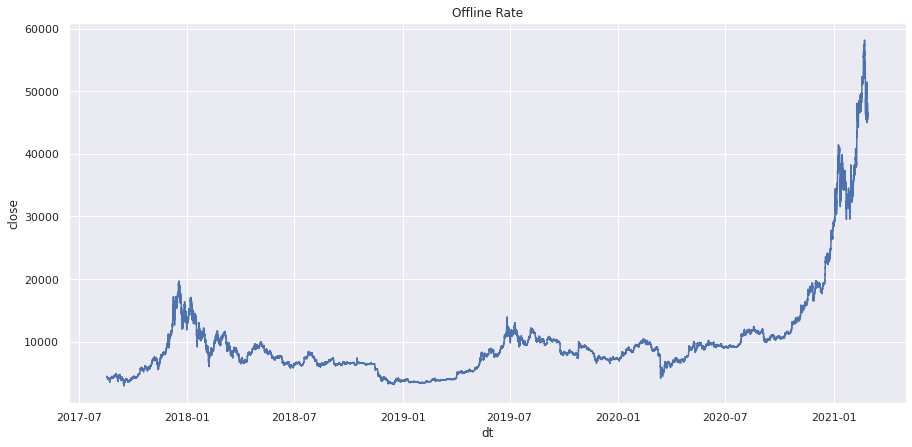

In [6]:
#  Constituição do DataFrame para treinamento
df_work = df_copy[['dt','hour','week_day','close','Volume BTC']]

plt.figure(figsize=(15,7))
sns.set()
sns.lineplot(x = df_work.dt, y = 'close',data=df_work).set_title('Offline Rate')

In [7]:
# DEFINIÇÃO DOS CONJUNTOS DE TREINO E TESTE
np.random.seed(7)

X = df_work[['hour','week_day','Volume BTC','close']]
Y = df_work[['close']]

# NOS COMENTÁRIOS VEJAM OPÇÕES DE PRÉ-PROCESSAMENTO

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = False)


#NORMALIZATION
f_transformer = preprocessing.MinMaxScaler((-1,1))
f_transformer = f_transformer.fit(X)
#X_train_trans = f_transformer.transform(X_train)
#X_test_trans = f_transformer.transform(X_test)

cnt_transformer = preprocessing.MinMaxScaler((-1,1))
cnt_transformer = cnt_transformer.fit(Y)
#y_train_trans = cnt_transformer.transform(y_train)
#y_test_trans = cnt_transformer.transform(y_test)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

X_train_trans = f_transformer.transform(X_train)
X_test_trans = f_transformer.transform(X_test)

y_train_trans = cnt_transformer.transform(y_train)
y_test_trans = cnt_transformer.transform(y_test)

#dump(f_transformer, '//Users//saad//Desktop//Bitcoin LSTM//minmax_scalar_x.bin', compress=True)
#dump(cnt_transformer, '//Users//saad//Desktop//Bitcoin LSTM//minmax_scalar_y.bin', compress=True)

print("*** SHAPES")
print("X_train: %s, %s" % (X_train.shape[0],X_train.shape[1]))
print("X_test: %s, %s" % (X_test.shape[0],X_test.shape[1]))
print("y_train: %s, %s" % (y_train.shape[0],y_train.shape[1]))
print("y_test: %s, %s" % (y_test.shape[0],y_test.shape[1]))

print("\n*** MIN MAX")

print("TRAIN COST: %d, %d" % (X_train.close.min(), X_train.close.max()))
print("TEST COST: %d, %d" % (X_test.close.min(), X_test.close.max()))
print("TRAIN VOL: %d, %d" % (X_train['Volume BTC'].min(), X_train['Volume BTC'].max()))
print("TEST VOL: %d, %d" % (X_test['Volume BTC'].min(), X_test['Volume BTC'].max()))

print("\n*** MIN MAX PARAMETER")
print(f_transformer.data_min_)
print(f_transformer.data_max_)
print(cnt_transformer.data_min_)
print(cnt_transformer.data_max_)

*** SHAPES
X_train: 26876, 4
X_test: 6720, 4
y_train: 26876, 1
y_test: 6720, 1

*** MIN MAX
TRAIN COST: 2919, 19709
TEST COST: 9946, 58183
TRAIN VOL: 0, 47255
TEST VOL: 0, 32057

*** MIN MAX PARAMETER
[   0.    0.    0. 2919.]
[2.300000e+01 6.000000e+00 4.725576e+04 5.818369e+04]
[2919.]
[58183.69]


In [8]:
# CRIAÇÃO DO DATASET POR PERÍODOS DA SÉRIE TEMPORAL
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
# reshape to [samples, time_steps, n_features]
X_train_f, y_train_f = create_dataset(X_train_trans, y_train_trans, time_steps)
X_test_f, y_test_f = create_dataset(X_test_trans, y_test_trans, time_steps)

print("*** SHAPES")
print(X_train_f.shape, y_train_f.shape)
print(X_test_f.shape, y_test_f.shape)
#print(X_train_trans.shape, y_train_trans.shape)
#print(X_test_trans.shape, y_test_trans.shape)

*** SHAPES
(26852, 24, 4) (26852, 1)
(6696, 24, 4) (6696, 1)


 
### EXECUÇÕES POSSÍVEIS PARA TESTE E GERAÇÃO DE MODELOS

#1 - LSTM 100, activation relu, batch 200, epoch 50
#2 - LSTM 100, activation tanh, batch 200, epoch 50
#3 - LSTM 300, activation relu, batch 200, epoch 50
#4 - LSTM 300, activation tanh, batch 200, epoch 50
#5 - LSTM 300, activation tanh, batch 200, epoch 50, dropout
#6 - 2xLSTM 150, activation tanh, batch 200, epoch 50 
#7 - 2xLSTM 300, activation tanh, batch 200, epoch 50 
#8 - Bi LSTM 300, activation tanh, batch 200, epoch 50
#9 - Bi LSTM 300, activation tanh, batch 200, epoch 50, batchnorm
#10 - Bi LSTM 300, activation tanh, batch 200, epoch 50, batchnorm, Dense10 
#11 - LSTM 300, activation tanh, batch 200, epoch 50, cnn1D 32f 7k 2st relu, 

In [9]:
#8 - Bi LSTM 300, activation tanh, batch 200, epoch 50
model = keras.Sequential()
model.add(keras.layers.Input(shape=((X_train_f.shape[1], X_train_f.shape[2]))))
model.add(layers.Bidirectional(layers.LSTM(300, activation = 'tanh', return_sequences=False)))
#model.add(layers.LSTM(150, return_sequences=True, activation = 'tanh')) #Se tiver mais de uma camada, cada camada recebe o parametro true
#model.add(layers.LSTM(150, return_sequences=False, activation = 'tanh')) #A ultima sequencia sempre é false
#model.add(layers.BatchNormalization())
#model.add(layers.Bidirectional(layers.LSTM(120,activation='relu', return_sequences=True)))
#model.add(keras.layers.Dropout(rate=0.2))
model.add(layers.Flatten())
#model.add(keras.layers.Dense(units=10, activation = 'relu'))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 600)              732000    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 732,601
Trainable params: 732,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
hist = model.fit(X_train_f, y_train_f, batch_size = 200, epochs = 50, shuffle=False, validation_split=0.1)

Epoch 1/50
121/121 [==============================] - 12s 44ms/step - loss: 0.0145 - val_loss: 0.0114
Epoch 2/50
121/121 [==============================] - 4s 35ms/step - loss: 0.0036 - val_loss: 0.0126
Epoch 3/50
121/121 [==============================] - 4s 36ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 4/50
121/121 [==============================] - 4s 35ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 5/50
121/121 [==============================] - 4s 36ms/step - loss: 0.0022 - val_loss: 0.0073
Epoch 6/50
121/121 [==============================] - 4s 36ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 7/50
121/121 [==============================] - 4s 36ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 8/50
121/121 [==============================] - 4s 35ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 9/50
121/121 [==============================] - 4s 36ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 10/50
121/121 [==============================] - 4s 35ms/step - loss: 0.0016 - val_l

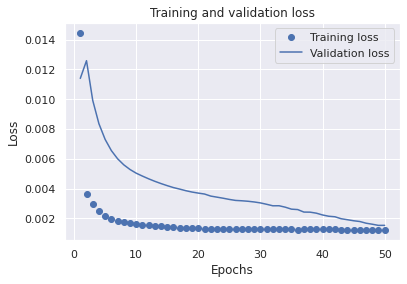

In [11]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import math

y_pred = model.predict(X_test_f) 

y_test_inv = cnt_transformer.inverse_transform(y_test_f)
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
combined_array = np.concatenate((y_test_inv,y_pred_inv),axis=1)
combined_array2 = np.concatenate((X_test.iloc[time_steps:],combined_array),axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head(4)
#testScore = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#print('Test Score: %.2f RMSE' % (testScore))
#combined_array

import math

y_pred = model.predict(X_test_f) 

y_test_inv = cnt_transformer.inverse_transform(y_test_f)
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
combined_array = np.concatenate((y_test_inv,y_pred_inv),axis=1)
combined_array2 = np.concatenate((X_test.iloc[time_steps:],combined_array),axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head(4)
#testScore = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#print('Test Score: %.2f RMSE' % (testScore))
#combined_array

size: 6696
size: 6696


,actual,predicted
0,10223.57,9175.720703
1,10284.47,9188.499023
2,10259.81,9216.252930
3,10260.75,9227.147461


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results = model.evaluate(X_test_f, y_test_f)

#print("accuracy: %s" % (accuracy_score(y_test_inv, y_pred_inv)))
print("mse: %s" % (mean_squared_error(y_test_inv, y_pred_inv)))
print(results)
#print(np.sqrt(mean_squared_error(y_test_f,y_pred)))
#55,699,935.99957543

210/210 [==============================] - 2s 9ms/step - loss: 0.0179
mse: 13641768.213669065
0.01786632090806961


In [14]:
## Preparar dados para plotagem
a = np.repeat(1, len(y_test_inv))
b = np.repeat(2, len(y_pred_inv))

df1 = pd.DataFrame(data = np.concatenate((y_test_inv,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
df2 = pd.DataFrame(data = np.concatenate((y_pred_inv,(np.reshape(b, (-1, 1)))),axis=1), columns=["price","type"])

frames = [df1, df2]
result = pd.concat(frames, ignore_index=False)

result["type"].replace({1: "actual", 2: "predict"}, inplace=True)
(result[result.type == "actual"]).head(10)

,price,type
0,10223.57,actual
1,10284.47,actual
2,10259.81,actual
3,10260.75,actual
4,10293.61,actual
5,10319.05,actual
6,10285.47,actual
7,10252.60,actual
8,10289.42,actual
9,10262.41,actual


In [15]:
fig = px.line(result, x=result.index.values, y="price", color='type', title='Bitcoin Price')
fig.show()